In [21]:
# 0. Bibliotheken importieren
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# 1. Daten laden
df = pd.read_csv('../../Data_Processing/whole_cleaned_dataset.csv')

In [23]:
# 2. Features und Zielspalte
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [24]:
# 3. Stratified K-Fold einrichten
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [25]:
# 4. Metriken speichern
precision_list = []
recall_list = []
f1_list = []
auc_list = []

mean_fpr = np.linspace(0, 1, 100)
tprs = []
conf_matrices = []

In [39]:
# 5. Cross-Validation Schleife
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = LogisticRegression(class_weight='balanced', max_iter=1000)
    model.fit(X_train, y_train)

    # Vorhersagen und Wahrscheinlichkeiten
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metriken berechnen
    precision_list.append(precision_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    f1_list.append(f1_score(y_test, y_pred))
    auc = roc_auc_score(y_test, y_proba)
    auc_list.append(auc)

    # Confusion Matrix berechnen
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices.append(cm)

    # ROC-Kurve für jeden Fold
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tprs.append(tpr_interp)

    print(f"Fold {fold}: Precision={precision_list[-1]:.2f}, Recall={recall_list[-1]:.2f}, F1={f1_list[-1]:.2f}, AUC={auc:.2f}")

    """
    #Show Confusion Matrix of each Fold
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues", xticklabels=["No Diabetes (0)", "Diabetes (1)"], yticklabels=["No Diabetes (0)", "Diabetes (1)"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Mean Confusion Matrix')
    plt.show()
    """


Fold 1: Precision=0.58, Recall=0.78, F1=0.67, AUC=0.84
Fold 2: Precision=0.75, Recall=0.80, F1=0.77, AUC=0.87
Fold 3: Precision=0.62, Recall=0.76, F1=0.68, AUC=0.85
Fold 4: Precision=0.65, Recall=0.74, F1=0.69, AUC=0.84
Fold 5: Precision=0.53, Recall=0.75, F1=0.62, AUC=0.81


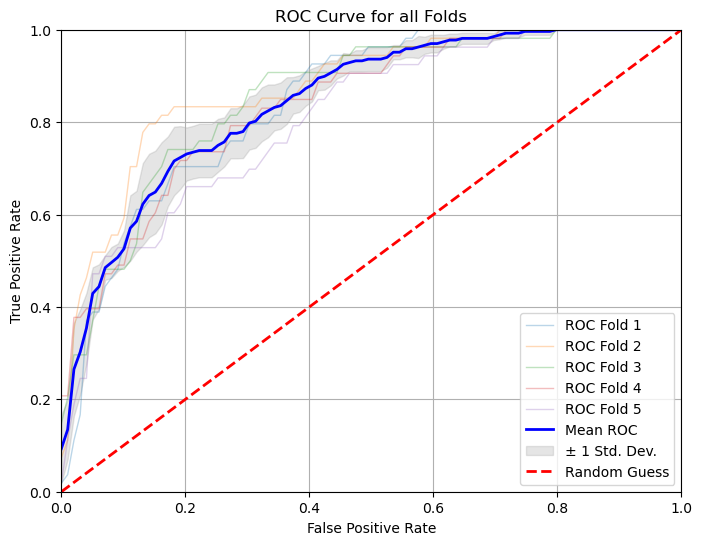

In [27]:
# ROC-Kurven aller Folds plotten
plt.figure(figsize=(8, 6))
for i, tpr in enumerate(tprs):
    plt.plot(mean_fpr, tpr, lw=1, alpha=0.3, label=f"ROC Fold {i + 1}")

mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
plt.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC', lw=2)
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 Std. Dev.')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw=2, label='Random Guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for all Folds')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

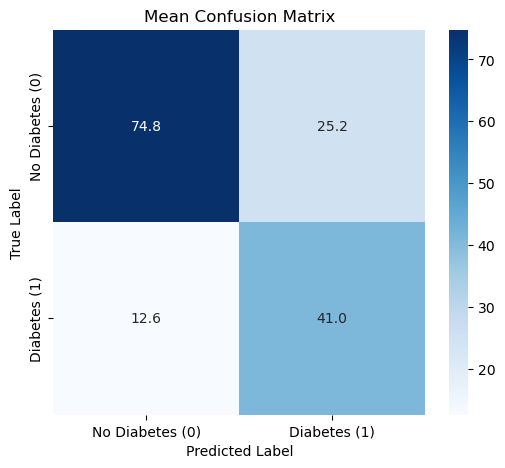

In [35]:
# Mean Confusion Matrix berechnen und plotten
mean_conf_matrix = np.mean(conf_matrices, axis=0)

plt.figure(figsize=(6, 5))
sns.heatmap(mean_conf_matrix, annot=True, fmt=".1f", cmap="Blues", xticklabels=["No Diabetes (0)", "Diabetes (1)"], yticklabels=["No Diabetes (0)", "Diabetes (1)"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Mean Confusion Matrix')
plt.show()

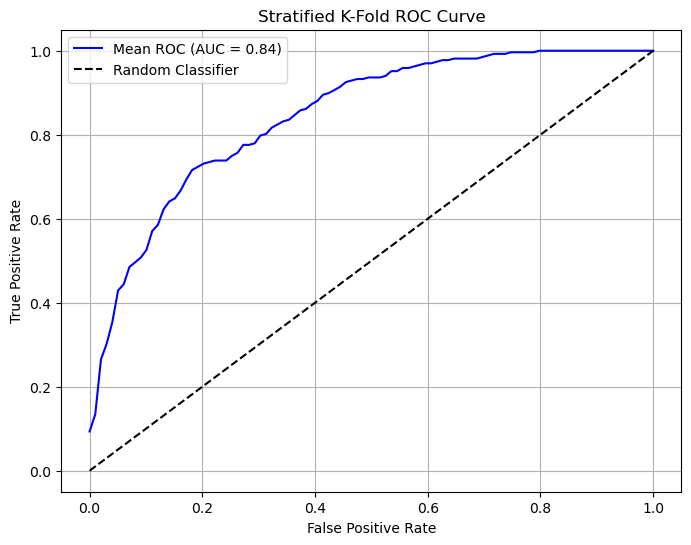

In [29]:
# 6. Durchschnittliche ROC-Kurve zeichnen
mean_tpr = np.mean(tprs, axis=0)
mean_auc = np.mean(auc_list)

plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, label=f'Mean ROC (AUC = {mean_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stratified K-Fold ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [33]:
# Zusammenfassung der Metriken
metrics = {
    "Precision": (np.mean(precision_list), np.std(precision_list)),
    "Recall": (np.mean(recall_list), np.std(recall_list)),
    "F1-Score": (np.mean(f1_list), np.std(f1_list)),
    "AUC": (np.mean(auc_list), np.std(auc_list))
}

print("=== Durchschnitt und Standardabweichung der Metriken ===")
for metric, (mean, std) in metrics.items():
    print(f"{metric}: Mittelwert = {mean:.3f}, Standardabweichung = {std:.3f}")
    print(f"{metric}: {mean:.3f} ± {std:.3f} ")


=== Durchschnitt und Standardabweichung der Metriken ===
Precision: Mittelwert = 0.627, Standardabweichung = 0.076
Precision: 0.627 ± 0.076 
Recall: Mittelwert = 0.765, Standardabweichung = 0.021
Recall: 0.765 ± 0.021 
F1-Score: Mittelwert = 0.687, Standardabweichung = 0.050
F1-Score: 0.687 ± 0.050 
AUC: Mittelwert = 0.842, Standardabweichung = 0.022
AUC: 0.842 ± 0.022 
